# SpringBoard Capstone2: Coronavirus Tweets Sentiment Analysis

    Data from Kaggle.com: https://www.kaggle.com/datatattle/covid-19-nlp-text-classification/metadata
## Data Explore and Preprocessing

In [3]:
!pip install stop-words

In [4]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /Users/Ling/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/Ling/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
# from wordcloud import WordCloud
import re
from sklearn.svm import LinearSVC

from sklearn import metrics
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
tweet_whole_train = pd.read_csv('/Users/Ling/Desktop/01_Springboard/Corona_Tweet/Data/Corona_NLP_train.csv', index_col = 0)
print(tweet_whole_train.info())
test = pd.read_csv('/Users/Ling/Desktop/01_Springboard/Corona_Tweet/Data/Corona_NLP_test.csv', index_col = 0)
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41157 entries, 3799 to 44955
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ScreenName     41157 non-null  int64 
 1   Location       32567 non-null  object
 2   TweetAt        41157 non-null  object
 3   OriginalTweet  41157 non-null  object
 4   Sentiment      41157 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3798 entries, 1 to 3798
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ScreenName     3798 non-null   int64 
 1   Location       2964 non-null   object
 2   TweetAt        3798 non-null   object
 3   OriginalTweet  3798 non-null   object
 4   Sentiment      3798 non-null   object
dtypes: int64(1), object(4)
memory usage: 178.0+ KB
None


In [7]:
print(tweet_whole_train.head())

          ScreenName   Location     TweetAt  \
UserName                                      
3799           48751     London  16-03-2020   
3800           48752         UK  16-03-2020   
3801           48753  Vagabonds  16-03-2020   
3802           48754        NaN  16-03-2020   
3803           48755        NaN  16-03-2020   

                                              OriginalTweet  \
UserName                                                      
3799      @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...   
3800      advice Talk to your neighbours family to excha...   
3801      Coronavirus Australia: Woolworths to give elde...   
3802      My food stock is not the only one which is emp...   
3803      Me, ready to go at supermarket during the #COV...   

                   Sentiment  
UserName                      
3799                 Neutral  
3800                Positive  
3801                Positive  
3802                Positive  
3803      Extremely Negative  


In [8]:
tweet = tweet_whole_train[['OriginalTweet', 'Sentiment']]

In [9]:
np.sum(tweet.isnull().any(axis=1))

0

In [10]:
np.unique(tweet.Sentiment, return_counts = True)

(array(['Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral',
        'Positive'], dtype=object),
 array([ 5481,  6624,  9917,  7713, 11422]))

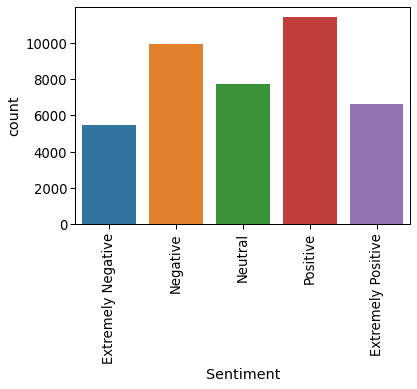

In [11]:
sns.set_context("paper", font_scale=1.5)
order = ['Extremely Negative', 'Negative', 'Neutral','Positive','Extremely Positive']
sns.countplot(x = 'Sentiment', data = tweet, order = order)
plt.xticks(rotation = 90)
plt.title = 'Training'
plt.show()

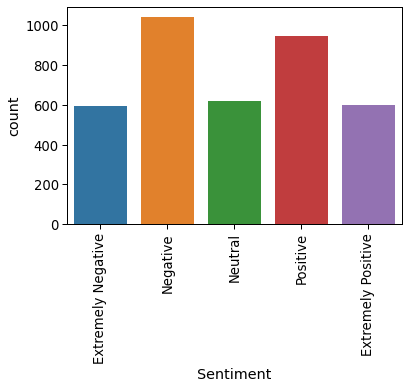

In [12]:
sns.set_context("paper", font_scale=1.5)
order = ['Extremely Negative', 'Negative', 'Neutral','Positive','Extremely Positive']
sns.countplot(x = 'Sentiment', data = test, order = order)
plt.xticks(rotation = 90)
plt.title = 'Test'
plt.show()

In [13]:
## Figures for slides
# sns.set_context("talk", font_scale=1.5)
# order = ['Extremely Negative', 'Negative', 'Neutral','Positive','Extremely Positive']
# sns.countplot(x = 'Sentiment', data = tweet, order = order)
# plt.xticks(rotation = 90)
# plt.show()

#### reference: https://www.analyticsvidhya.com/blog/2021/06/twitter-sentiment-analysis-a-nlp-use-case-for-beginners/

In [14]:
# lower case all text
tweet['OriginalTweet'] = tweet['OriginalTweet'].str.lower()
test['OriginalTweet'] = test['OriginalTweet'].str.lower()

print('TRAIN DATA \n', tweet['OriginalTweet'].head())
print('\n TEST DATA \n', test['OriginalTweet'].head())

TRAIN DATA 
 UserName
3799    @menyrbie @phil_gahan @chrisitv https://t.co/i...
3800    advice talk to your neighbours family to excha...
3801    coronavirus australia: woolworths to give elde...
3802    my food stock is not the only one which is emp...
3803    me, ready to go at supermarket during the #cov...
Name: OriginalTweet, dtype: object

 TEST DATA 
 UserName
1    trending: new yorkers encounter empty supermar...
2    when i couldn't find hand sanitizer at fred me...
3    find out how you can protect yourself and love...
4    #panic buying hits #newyork city as anxious sh...
5    #toiletpaper #dunnypaper #coronavirus #coronav...
Name: OriginalTweet, dtype: object


<ipython-input-14-f65a37d2acef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['OriginalTweet'] = tweet['OriginalTweet'].str.lower()


In [15]:
def remove_at_signs(text):
    return " ".join([word for word in str(text).split() if not word.startswith('@')])
tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda text: remove_at_signs(text))
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda text: remove_at_signs(text))

print('TRAIN DATA \n', tweet['OriginalTweet'].head())
print('\n TEST DATA \n', test['OriginalTweet'].head())

TRAIN DATA 
 UserName
3799    https://t.co/ifz9fan2pa and https://t.co/xx6gh...
3800    advice talk to your neighbours family to excha...
3801    coronavirus australia: woolworths to give elde...
3802    my food stock is not the only one which is emp...
3803    me, ready to go at supermarket during the #cov...
Name: OriginalTweet, dtype: object

 TEST DATA 
 UserName
1    trending: new yorkers encounter empty supermar...
2    when i couldn't find hand sanitizer at fred me...
3    find out how you can protect yourself and love...
4    #panic buying hits #newyork city as anxious sh...
5    #toiletpaper #dunnypaper #coronavirus #coronav...
Name: OriginalTweet, dtype: object


<ipython-input-15-924ac800784c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda text: remove_at_signs(text))


In [16]:
import itertools
def cleaning_repeating_char(text):
    cl = ''.join(ch for ch, _ in itertools.groupby(text))
    return cl
tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda x: cleaning_repeating_char(x))
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x: cleaning_repeating_char(x))

print('TRAIN DATA \n', tweet['OriginalTweet'].head())
print('\n TEST DATA \n', test['OriginalTweet'].head())

TRAIN DATA 
 UserName
3799    htps:/t.co/ifz9fan2pa and htps:/t.co/x6ghgfzc ...
3800    advice talk to your neighbours family to excha...
3801    coronavirus australia: wolworths to give elder...
3802    my fod stock is not the only one which is empt...
3803    me, ready to go at supermarket during the #cov...
Name: OriginalTweet, dtype: object

 TEST DATA 
 UserName
1    trending: new yorkers encounter empty supermar...
2    when i couldn't find hand sanitizer at fred me...
3    find out how you can protect yourself and love...
4    #panic buying hits #newyork city as anxious sh...
5    #toiletpaper #dunypaper #coronavirus #coronavi...
Name: OriginalTweet, dtype: object


<ipython-input-16-8d4802ada748>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda x: cleaning_repeating_char(x))


In [17]:
def cleaning_URLs(data):
    return re.sub('[^ ]+\.[^ ]+' , ' url', data)
tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda x: cleaning_URLs(x))
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x: cleaning_URLs(x))

print('TRAIN DATA \n', tweet['OriginalTweet'].head())
print('\n TEST DATA \n', test['OriginalTweet'].head())

TRAIN DATA 
 UserName
3799                                url and  url and  url
3800    advice talk to your neighbours family to excha...
3801    coronavirus australia: wolworths to give elder...
3802    my fod stock is not the only one which is empt...
3803    me, ready to go at supermarket during the #cov...
Name: OriginalTweet, dtype: object

 TEST DATA 
 UserName
1    trending: new yorkers encounter empty supermar...
2    when i couldn't find hand sanitizer at fred me...
3    find out how you can protect yourself and love...
4    #panic buying hits #newyork city as anxious sh...
5    #toiletpaper #dunypaper #coronavirus #coronavi...
Name: OriginalTweet, dtype: object


<ipython-input-17-1b8d7a4d6e5f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda x: cleaning_URLs(x))


In [18]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans(' ', ' ', punctuations_list)
    return text.translate(translator)
tweet['OriginalTweet']= tweet['OriginalTweet'].apply(lambda x: cleaning_punctuations(x))
test['OriginalTweet']= test['OriginalTweet'].apply(lambda x: cleaning_punctuations(x))

print('TRAIN DATA \n', tweet['OriginalTweet'].head())
print('\n TEST DATA \n', test['OriginalTweet'].head())

TRAIN DATA 
 UserName
3799                                url and  url and  url
3800    advice talk to your neighbours family to excha...
3801    coronavirus australia wolworths to give elderl...
3802    my fod stock is not the only one which is empt...
3803    me ready to go at supermarket during the covid...
Name: OriginalTweet, dtype: object

 TEST DATA 
 UserName
1    trending new yorkers encounter empty supermark...
2    when i couldnt find hand sanitizer at fred mey...
3    find out how you can protect yourself and love...
4    panic buying hits newyork city as anxious shop...
5    toiletpaper dunypaper coronavirus coronavirusa...
Name: OriginalTweet, dtype: object


<ipython-input-18-07738a1d2c6a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['OriginalTweet']= tweet['OriginalTweet'].apply(lambda x: cleaning_punctuations(x))


In [19]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda x: cleaning_numbers(x))
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x: cleaning_numbers(x))

print('TRAIN DATA \n', tweet['OriginalTweet'].head())
print('\n TEST DATA \n', test['OriginalTweet'].head())

TRAIN DATA 
 UserName
3799                                url and  url and  url
3800    advice talk to your neighbours family to excha...
3801    coronavirus australia wolworths to give elderl...
3802    my fod stock is not the only one which is empt...
3803    me ready to go at supermarket during the covid...
Name: OriginalTweet, dtype: object

 TEST DATA 
 UserName
1    trending new yorkers encounter empty supermark...
2    when i couldnt find hand sanitizer at fred mey...
3    find out how you can protect yourself and love...
4    panic buying hits newyork city as anxious shop...
5    toiletpaper dunypaper coronavirus coronavirusa...
Name: OriginalTweet, dtype: object


<ipython-input-19-89c92968cac6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda x: cleaning_numbers(x))


In [20]:
# from stop_words import get_stop_words
# from nltk.corpus import stopwords

# stop_words = list(get_stop_words('en'))        
# nltk_words = list(stopwords.words('english')) 
# stop_words.extend(nltk_words)

# stopwordlist = ['a','across','ain', 'am', 'an',
#              'and','any','are', 'as', 'at', 'be',  'before',
#              'being', 'between', 'by', 'can', 'd', 'do',
#              'does', 'doing',  'during',  'for', 'from',
#              'had', 'has', 'have', 'having', 'he', 'her', 'here',
#              'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'im','in',
#              'into','is', 'it', 'its', 'itself', 'll','l', 'm', 'ma',
#              'me', 'my', 'myself', 'now', 'o', 'of', 'on', 'once',
#              'or',  'our', 'ours','ourselves',  'own', 're','s', 'she', "shes", 
#              't', 'than', 'that', "thatl",'thatll' , 'the', 'their', 'theirs', 'them',
#              'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
#              'through', 'to', 've', 
#              'we',  'what', 'when', 'where','which','while', 'who', 'whom',
#              'why', 'wil', 'will', 'with', 'y', 'you', "youd","youl", 'youll', "youre",
#              "youve", 'your', 'yours', 'yourself', 'yourselves']
# stop_words.extend(stopwordlist)
# len(stop_words)

In [21]:
# unique_stop = list(dict.fromkeys(stop_words))
# unique_stop

In [22]:
stop_words = ['a',
 'about',
 'above',
 'after',
 'am',
 'all',
              'al',
              
              'an',
 'and',
 'any',
 'are',
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'but',
 'by',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'down',
 'during',
 'each',
 'for',
 'from',
 'further',
 'had',
 'has',
 'have',
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'it',
 "it's",
 'its',
 'itself',
 "let's",
 'me',
 'my',
 'myself',
 'of',
 'off',
 'on',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'same',
 'she',
 "she'd",
 "she'll",
 "she's",
 'should',
 'so',
 'some',
 'such',
 'than',
 'that',
 "that's",
 'the',
 'their',
 'theirs',
 'them',
 'themselves',
 'then',
 'there',
 "there's",
 'these',
 'they',
 "they'd",
 "they'll",
 "they're",
 "they've",
 'this',
 'those',
 'through',
 'to',
 'under',
 'until',
 'up',
 'very',
 'was',
 'we',
 "we'd",
 "we'll",
 "we're",
 "we've",
 'were',
 'what',
 "what's",
 'when',
 "when's",
 'where',
 "where's",
 'which',
 'while',
 'who',
 "who's",
 'whom',
 'why',
 "why's",
 'with',
 "won't",
 'would',
 'you',
 "you'd",
 "you'll",
 "you're",
 "you've",
 'your',
 'yours',
 'yourself',
 'yourselves',
 "that'll",
 's',
 't',
 'can',
 'will',
 'just',
 'don',
 "should've",
 'now',
 'd',
 'll',
 'm',
 'o',
 're',
 've',
 'y',
 'ma',
 'across',
 'im',
 'l',
 'shes',
 'thatl',
 'thatll',
 'wil',
 'youd',
 'youl',
 'youll',
 'youre',
 'youve']

In [23]:
STOPWORDS = set(stop_words)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda text: cleaning_stopwords(text))
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda text: cleaning_stopwords(text))

print('TRAIN DATA \n', tweet['OriginalTweet'].head())
print('\n TEST DATA \n', test['OriginalTweet'].head())

TRAIN DATA 
 UserName
3799                                          url url url
3800    advice talk neighbours family exchange phone n...
3801    coronavirus australia wolworths give elderly d...
3802    fod stock not only one empty please dont panic...
3803    ready go supermarket covid outbreak not parano...
Name: OriginalTweet, dtype: object

 TEST DATA 
 UserName
1    trending new yorkers encounter empty supermark...
2    couldnt find hand sanitizer fred meyer turned ...
3                  find protect loved ones coronavirus
4    panic buying hits newyork city anxious shopers...
5    toiletpaper dunypaper coronavirus coronavirusa...
Name: OriginalTweet, dtype: object


<ipython-input-23-e727e90cafac>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda text: cleaning_stopwords(text))


In [24]:
# # Remove non_English words, THIS is not a good step, but code saved for future.
# import nltk
# nltk.download('words')
# words = set(nltk.corpus.words.words())
# def remove_non_english(text):
#     eng = " ".join(w for w in nltk.wordpunct_tokenize(text) \
#          if w.lower() in words or not w.isalpha())
#     return eng

# tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda x: remove_non_english(x))
# tweet['OriginalTweet'].head(10)

In [25]:
# Tokenize the OriginalTweet text
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
tweet['Tokens'] = [tknzr.tokenize(t) for t in tweet['OriginalTweet']]
test['Tokens'] = [tknzr.tokenize(t) for t in test['OriginalTweet']]

print('TRAIN DATA \n', tweet['Tokens'].head())
print('\n TEST DATA \n', test['Tokens'].head())

<ipython-input-25-e18c1b857b21>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['Tokens'] = [tknzr.tokenize(t) for t in tweet['OriginalTweet']]


TRAIN DATA 
 UserName
3799                                      [url, url, url]
3800    [advice, talk, neighbours, family, exchange, p...
3801    [coronavirus, australia, wolworths, give, elde...
3802    [fod, stock, not, only, one, empty, please, do...
3803    [ready, go, supermarket, covid, outbreak, not,...
Name: Tokens, dtype: object

 TEST DATA 
 UserName
1    [trending, new, yorkers, encounter, empty, sup...
2    [couldnt, find, hand, sanitizer, fred, meyer, ...
3            [find, protect, loved, ones, coronavirus]
4    [panic, buying, hits, newyork, city, anxious, ...
5    [toiletpaper, dunypaper, coronavirus, coronavi...
Name: Tokens, dtype: object


In [26]:
### Checking tags may be useful

## Tokenize using work_tokenize
# nltk.download('punkt')
# tweet['Words'] = nltk.word_tokenize(tweet['text'])
# def remove_all_prepositions(text):
#     return " ".join([word for word in str(text).split() if word not in STOPWORDS])
# tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda text: cleaning_stopwords(text))
# tweet['OriginalTweet'].head()

nltk.download('averaged_perceptron_tagger')
tag1 = nltk.pos_tag(tweet.iloc[20011,2])
tag1

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Ling/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('please', 'NN'),
 ('remain', 'VBP'),
 ('vigilant', 'JJ'),
 ('report', 'NN'),
 ('suspected', 'VBD'),
 ('fraud', 'NN'),
 ('schemes', 'NNS'),
 ('involving', 'VBG'),
 ('covid', 'NN'),
 ('caling', 'VBG'),
 ('national', 'JJ'),
 ('center', 'NN'),
 ('disaster', 'NN'),
 ('fraud', 'NN'),
 ('hotline', 'NN'),
 ('emailing', 'VBG'),
 ('url', 'RB'),
 ('more', 'JJR'),
 ('information', 'NN'),
 ('avoid', 'IN'),
 ('coronavirus', 'NN'),
 ('related', 'JJ'),
 ('scams', 'NNS'),
 ('url', 'VBP')]

In [27]:
lm = nltk.stem.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
tweet['Tokens'] = tweet['Tokens'].apply(lambda x: lemmatizer_on_text(x))
test['Tokens'] = test['Tokens'].apply(lambda x: lemmatizer_on_text(x))

print('TRAIN DATA \n', tweet['Tokens'].head())
print('\n TEST DATA \n', test['Tokens'].head())

<ipython-input-27-61c95a0fc1b3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['Tokens'] = tweet['Tokens'].apply(lambda x: lemmatizer_on_text(x))


TRAIN DATA 
 UserName
3799                                      [url, url, url]
3800    [advice, talk, neighbours, family, exchange, p...
3801    [coronavirus, australia, wolworths, give, elde...
3802    [fod, stock, not, only, one, empty, please, do...
3803    [ready, go, supermarket, covid, outbreak, not,...
Name: Tokens, dtype: object

 TEST DATA 
 UserName
1    [trending, new, yorkers, encounter, empty, sup...
2    [couldnt, find, hand, sanitizer, fred, meyer, ...
3            [find, protect, loved, ones, coronavirus]
4    [panic, buying, hits, newyork, city, anxious, ...
5    [toiletpaper, dunypaper, coronavirus, coronavi...
Name: Tokens, dtype: object


In [28]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
tweet['Tokens']= tweet['Tokens'].apply(lambda x: stemming_on_text(x))
tweet['Tokens'].head(10)

<ipython-input-28-9e413b8e77ce>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['Tokens']= tweet['Tokens'].apply(lambda x: stemming_on_text(x))


UserName
3799                                      [url, url, url]
3800    [advice, talk, neighbours, family, exchange, p...
3801    [coronavirus, australia, wolworths, give, elde...
3802    [fod, stock, not, only, one, empty, please, do...
3803    [ready, go, supermarket, covid, outbreak, not,...
3804    [news, region, , s, first, confirmed, covid, ...
3805    [cashier, grocery, store, sharing, insights, c...
3806    [supermarket, today, didnt, buy, toilet, paper...
3807    [due, covid, retail, store, clasrom, atlanta, ...
3808    [corona, preventionwe, stop, buy, things, cash...
Name: Tokens, dtype: object

In [29]:
tweet['text'] = tweet["Tokens"].map(' '.join)
test['text'] = test["Tokens"].map(' '.join)

print('TRAIN DATA \n', tweet['text'].head())
print('\n TEST DATA \n', test['text'].head())

TRAIN DATA 
 UserName
3799                                          url url url
3800    advice talk neighbours family exchange phone n...
3801    coronavirus australia wolworths give elderly d...
3802    fod stock not only one empty please dont panic...
3803    ready go supermarket covid outbreak not parano...
Name: text, dtype: object

 TEST DATA 
 UserName
1    trending new yorkers encounter empty supermark...
2    couldnt find hand sanitizer fred meyer turned ...
3                  find protect loved ones coronavirus
4    panic buying hits newyork city anxious shopers...
5    toiletpaper dunypaper coronavirus coronavirusa...
Name: text, dtype: object


<ipython-input-29-b431f87894f4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['text'] = tweet["Tokens"].map(' '.join)


In [30]:
## This step also tried, muted because better result with SVC
# from sklearn.preprocessing import MultiLabelBinarizer
# from sklearn.model_selection import train_test_split 

# X = tweet['Tokens']
# y = tweet['Sentiment']

# # Vectorize the X
# MLB_vect = MultiLabelBinarizer()
# MLB_X_train = MLB_vect.fit_transform(X_train)
# MLB_X_test = MLB_vect.transform(X_test)
# len(MLB_vect.classes_)

In [31]:
STOPWORDS = set(stop_words)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
tweet['text'] = tweet['text'].apply(lambda text: cleaning_stopwords(text))
test['text'] = test['text'].apply(lambda text: cleaning_stopwords(text))

print('TRAIN DATA \n', tweet['text'].head())
print('\n TEST DATA \n', test['text'].head())

TRAIN DATA 
 UserName
3799                                          url url url
3800    advice talk neighbours family exchange phone n...
3801    coronavirus australia wolworths give elderly d...
3802    fod stock not only one empty please dont panic...
3803    ready go supermarket covid outbreak not parano...
Name: text, dtype: object

 TEST DATA 
 UserName
1    trending new yorkers encounter empty supermark...
2    couldnt find hand sanitizer fred meyer turned ...
3                  find protect loved ones coronavirus
4    panic buying hits newyork city anxious shopers...
5    toiletpaper dunypaper coronavirus coronavirusa...
Name: text, dtype: object


<ipython-input-31-ad510adabaa2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['text'] = tweet['text'].apply(lambda text: cleaning_stopwords(text))


In [43]:
tweet.to_csv('ProcessedTweets', columns = ['text', 'Sentiment'])

test.to_csv('ProcessedTestData', columns = ['text', 'Sentiment'])

In [32]:
# This step tried before tfidf, but results better with tfidf, so muted this cell
from sklearn.feature_extraction.text import CountVectorizer  
from sklearn.model_selection import train_test_split 

X = tweet['text'] 
y = tweet['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)

Count_vect = CountVectorizer(ngram_range=(1, 1), max_df=0.7, min_df=15)

Count_train = Count_vect.fit_transform(X_train)
Count_test = Count_vect.transform(X_test)
print(Count_vect.get_feature_names()[:10])
print('# of feature names', len(Count_vect.get_feature_names()))

['ability', 'able', 'absolute', 'absolutely', 'absurd', 'abt', 'abuse', 'ac', 'acelerate', 'acelerated']
# of feature names 4507


In [33]:
#  TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 

X = tweet['text'] 
y = tweet['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), min_df = 15, max_df = 0.7)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

# Print the first 10 features
print('# of feature names', len(tfidf_vectorizer.get_feature_names()))
print(tfidf_vectorizer.get_feature_names()[100:200])
#print(tfidf_vectorizer.get_feature_names()[-100:])

# Print the first 5 vectors of the tfidf training data
print(tfidf_train.A[5])

# of feature names 4507
['alcoholbased', 'aldi', 'alegedly', 'alergies', 'alert', 'alive', 'almost', 'alone', 'along', 'alongside', 'alow', 'alowed', 'alowing', 'alows', 'already', 'also', 'alternative', 'alternatives', 'although', 'always', 'amazing', 'amazon', 'ambulance', 'america', 'american', 'americans', 'amid', 'amidst', 'amo', 'among', 'amongst', 'amount', 'amounts', 'amp', 'ample', 'analysis', 'analyst', 'analysts', 'analytics', 'andor', 'angela', 'angeles', 'angry', 'animal', 'animals', 'another', 'anounce', 'anounced', 'anouncement', 'anouncements', 'anounces', 'anouncing', 'answer', 'answered', 'answers', 'anti', 'antibacterial', 'anticipate', 'anual', 'anxiety', 'anxious', 'anybody', 'anymore', 'anyone', 'anything', 'anyway', 'anywhere', 'ap', 'aparel', 'aparently', 'apart', 'apartment', 'apeal', 'apear', 'apears', 'aple', 'aplications', 'aplied', 'aplies', 'aply', 'apocalypse', 'apr', 'apreciate', 'apreciated', 'apreciation', 'april', 'aproach', 'apropriate', 'aprove', 'a

In [34]:
## Try NaiveBayes first
# Import the necessary modules

# from sklearn.naive_bayes import MultinomialNB 
# from sklearn.ensemble import RandomForestClassifier

# # using tfidf ## F1 0.44 fast to run
# NB_classifier = MultinomialNB()
# # Fit the classifier to the training data
# NB_classifier.fit(tfidf_train, y_train)
# # Create the predicted tags: pred
# pred = NB_classifier.predict(tfidf_test)
# # Calculate the accuracy score: score
# Score = metrics.accuracy_score(y_test, pred)
# print(Score)
# # Calculate the confusion matrix: cm
# CM = metrics.confusion_matrix(y_test, pred)
# print(CM)


# # Using Count_train
# nb_classifier = MultinomialNB()
# # Fit the classifier to the training data
# nb_classifier.fit(Count_train, y_train)
# # Create the predicted tags: pred
# pred = nb_classifier.predict(Count_test)
# # Calculate the accuracy score: score
# score = metrics.accuracy_score(y_test, pred)
# print(Score)
# # Calculate the confusion matrix: cm
# cm = metrics.confusion_matrix(y_test, pred)
# print(CM)

# # F1 = 0.49 fast to run
# BNBmodel = BernoulliNB()
# BNBmodel.fit(tfidf_train, y_train)
# y_pred = BNBmodel.predict(tfidf_test)
# print(classification_report(y_test, y_pred))
# print(metrics.accuracy_score(y_test, y_pred))

# ## F1 LinearSVC = 0.56
# from sklearn.svm import LinearSVC
# SVCLinear = LinearSVC()
# SVCLinear.fit(tfidf_train, y_train)
# y_pred = SVCLinear.predict(tfidf_test)
# print(classification_report(y_test, y_pred))
# print('F1 accuracy: ', metrics.accuracy_score(y_test, y_pred))
# CM = metrics.confusion_matrix(y_test, y_pred, normalize='true')
# print(CM)

## use count_train and count_test
from sklearn.svm import LinearSVC
SVCLinear = LinearSVC()
SVCLinear.fit(Count_train, y_train)
y_pred = SVCLinear.predict(Count_test)
print(classification_report(y_test, y_pred))
print('F1 accuracy: ', metrics.accuracy_score(y_test, y_pred))
CM = metrics.confusion_matrix(y_test, y_pred)
print(CM)


wt = SVCLinear.coef_[0]
sorted_index = np.argsort(wt)[::-1]
terms = Count_vect.get_feature_names()
sorted_features = []
for ind in sorted_index:
    sorted_features.append(terms[ind])
print(sorted_features[:100])

/Users/Ling/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


                    precision    recall  f1-score   support

Extremely Negative       0.60      0.64      0.62       790
Extremely Positive       0.67      0.71      0.69      1005
          Negative       0.53      0.47      0.50      1516
           Neutral       0.62      0.73      0.67      1176
          Positive       0.56      0.52      0.54      1687

          accuracy                           0.59      6174
         macro avg       0.60      0.61      0.60      6174
      weighted avg       0.59      0.59      0.59      6174

F1 accuracy:  0.5913508260447036
[[507   6 211  28  38]
 [  9 710  39  30 217]
 [266  47 708 224 271]
 [ 23  18 117 857 161]
 [ 37 278 269 234 869]]
['riots', 'fucked', 'evil', 'pised', 'dead', 'kil', 'kiling', 'worst', 'crisis', 'hel', 'abuse', 'kiled', 'criminals', 'iresponsible', 'fraudsters', 'threatens', 'destroyed', 'bastards', 'dumb', 'shocked', 'atack', 'bitch', 'exploiting', 'destruction', 'fuck', 'devastating', 'threats', 'severely', 'negative

In [35]:
df = pd.DataFrame(zip(sorted_features,np.sort(wt)[::-1]), columns = ['Features', 'Coef'])
df.head(20)

,Features,Coef
0,riots,2.333711
1,fucked,2.245244
2,evil,2.216305
3,pised,2.205473
4,dead,2.185072
5,kil,2.150183
6,kiling,2.143915
7,worst,2.085018
8,crisis,2.031738
9,hel,1.938605
